<a href="https://colab.research.google.com/github/toritori777/healthapp/blob/main/noom_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installations

In [28]:
!pip3 install clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [29]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import collections
import math
import matplotlib.pyplot as plt
from collections import Counter
from nltk import ngrams
import re
from cleantext import clean
import cleantext

## Numpy utility functions

In [30]:
def as_1d(v):
    """Convert row or column vector to 1D
    """
    v_1d = np.atleast_1d(np.squeeze(v))
    if (len(v_1d.shape) != 1):
        raise Exception(f"Array is not a vector, has squeezed dimension {v_1d.shape}")
    return v_1d

def as_col(v):
    """Convert vector to column
    """
    return as_1d(v).reshape(-1, 1)
    
def as_row(v):
    """Convert vector to row
    """
    return as_1d(v).reshape(1, -1)

# Data Processing

### Get files from GitHub

In [31]:
# Install subversion to use svn
!apt-get install subversion

# Get what you want by adding "/trunk" to the repo url and the folder you want
#!svn checkout REPO_URL/trunk/DIRECTORY
!svn checkout https://github.com/toritori777/healthapp.git/trunk

Reading package lists... Done
Building dependency tree       
Reading state information... Done
subversion is already the newest version (1.9.7-4ubuntu1.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Checked out revision 2.


### Read datasets

In [32]:
class Dataset(object):
    def __init__(self, folder_path, name = None):
        if name is None:
            self.string_rep = str(folder_path)
        else:
            self.string_rep = name

        self.data = pd.read_csv(Path(folder_path))
        self.rating = as_1d(self.data["content/rating"].to_numpy()) # (n) array
        self.title = as_col(self.data["content/title"].to_numpy()) # (n x 1) array
        self.body = as_col(self.data["content/body"].to_numpy()) # (n x 1) array

    def __repr__(self):
        return str(self.string_rep)

    def __str__(self):
        return self.__repr__()

In [33]:
noom_ios = Dataset("trunk/noom_ios.csv", "noom ios")
noom_android = Dataset("trunk/noom_android.csv", "noom android")

### Clean Data

In [34]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def preprocessing_dataset(x):
  
  try:
    x = re.sub('\n',' ',x)
  except:   #for the reddit dataset
    x = str(x)
    x = re.sub('\n',' ',x) 
  x = remove_emoji(x) #removes emoji
  x = clean(x, no_emoji=True) #removes emoji
  x = re.sub(r"http\S+", "<URL>", x) #replaces general url
  x = clean(x, no_urls = True, replace_with_url="<URL>") #replaces all urls
  x = clean(x, no_phone_numbers=True, replace_with_phone_number="<PHONE>") #replaces any phone num
  x = clean(x, no_emails=True, replace_with_email="<EMAIL>") #replaces any email
  x = re.sub('@[^\s]+','<USERID>',x) #replaces any userid with a generic one
  x = x.replace("newline", "") #
  x = x.replace("linebreak", "") 
    
  return x

def preprocess_dataset(ds):
  preprocess = np.vectorize(preprocessing_dataset)
  ds.title = preprocess(ds.title)
  ds.body = preprocess(ds.body)
  return ds

In [35]:
noom_ios = preprocess_dataset(noom_ios)
noom_android = preprocess_dataset(noom_android)

### Rating Distribution

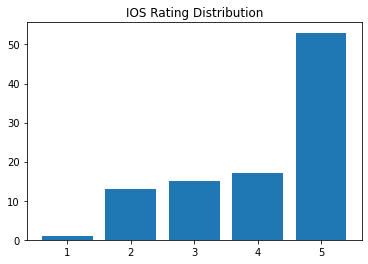

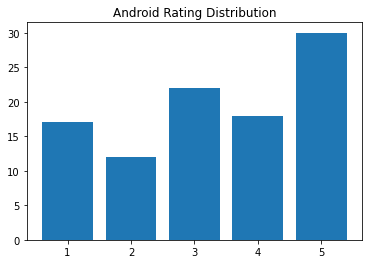

In [36]:
unique, counts = np.unique(noom_ios.rating, return_counts=True)
plt.bar(unique, counts) 
plt.title("IOS Rating Distribution")
plt.show()

unique1, counts1 = np.unique(noom_android.rating, return_counts=True)
plt.bar(unique1, counts1) 
plt.title("Android Rating Distribution")
plt.show()

### Comments with rating <= 3

In [37]:
body_df = pd.DataFrame(noom_ios.body)
body_df.columns = ['body']
rating_df = pd.DataFrame(noom_ios.rating)
rating_df.columns = ['rating']
ios_df = pd.concat([rating_df, body_df], axis = 1, sort = False)
pd.set_option('display.max_colwidth', -1) 
low_rating_ios_df = ios_df[ios_df['rating'] <= 3] 
low_rating_ios_df

<ipython-input-37-c85681066725>:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,rating,body
11,3,"i was doing great with this app. i love the articles that they have to read, the way that they show you how to choose your food wisely so you can keep on track. however, i was logged off by the app and required to sign back in. have not been able to get back on the app since january 1, 2021. i've contacted support and at least 3 to 4 times a day i get the same suggestion to fix my problem from a different person at support. i just realized tonight that it is coming from zendesk which is an app and not real people which explains why i am being told to do the same thing over and over again that does not work. there is no way to contact a person at noom to get help. i am so disappointed that i cannot use this app any longer. i even tried starting a new account with a different email and it still keeps bringing me to the window to upgrade which means i have to pay again and i have done this twice with no luck. every time i sign in it comes back to the i want to upgrade window and will not allow me into the actual app. it is so frustrating not to be able to talk to someone to get help with this. i really wanted to continue to use this app and had planned on paying the $200 for the year to reward myself on new year's day but found myself locked out. i even sent an email to the ceo, saeju joeng and received a reply from zendesk. i was only able to use this app for 4 months.\ngreat app if you are able to use it."
16,3,"i have been using noom on and off for 4 years after successful weight loss but the one thing i always hated is that they say you can customize your own recipe but that is not true. the calories is automatically generated and is always wrong. for example, i am trying to log a recipe with 725 calories, it automatically makes it 2725 calories and you can't change/correct it. i was told by support that it can take 3-6 months for the recipe to be in the system. what if you want to log it because you just had it and want to stay on track with your calories but can't see it in your calorie bar because it is incorrect? there is no place to type the correct information. makes no sense why noom doesn't have it and lifesum does. i might switch to lifesum because i do not want to wait 3-6 months to log a recipe i just ate. i want to know how much i eat calorie wise. noom should have made it so it so you can fully customize your dish and nutrition info. this is the biggest let down of the app.\ni have talked to support about this 5 times in the past 2 days and most of them are clueless to what i want and those that do understand say ""it can take up to 3-6 months for it to finalize"". i have tried this before and it never goes through. i tried 2 years ago and do you think anything happened? nope. really upset with how noom handles this. just make it so we can enter are own nutrition information. lifesum does it"
25,3,"the first 2 levels of lessons (equivalent to 1.5 months of the program) were interesting and offered useful information about how to look at food and your food habits. however after completing the second level of lessons the information became uninteresting and wasn't adding up to my knowledge. second, i entered a plateau in the third week of the program that i couldn't get out from in four weeks. i started counting macros and my weight started shifting down again. this made me realize that noom's system of food tracking based on colors was not helping me loose weight as i was filling up my diet with carbs (fruit and vegetables and some grains). when i turned to the in-demand coaching it was a huge dissatisfaction because i went in circles with them for three weeks - they would tell me that i plateaud because i was eating too little calories, only to realize they were wrong every time (this happened three times). when i moved to the 'goal coach' it was also disappointing because instead of giving me advice she literally said 'loosing 6 pounds might be tricky, but you know what to do so you got it!' r

In [38]:
body_df = pd.DataFrame(noom_android.body)
body_df.columns = ['body']
rating_df = pd.DataFrame(noom_android.rating)
rating_df.columns = ['rating']
android_df = pd.concat([rating_df, body_df], axis = 1, sort = False)
pd.set_option('display.max_colwidth', -1) 
low_rating_android_df = android_df[android_df['rating'] <= 3] 
low_rating_android_df

<ipython-input-38-92ede3aff470>:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,rating,body
0,1,"the actual nutrition course is really nice and well put together. but all the other features are pretty bland and just worse versions of other apps. the food logger isn't particularly good, and there's no way to connect to a better one. or more than 1 device. you can pretty much connect a watch and that's it. it gets advertised with some sort of assistance (coach?), but it's a bot that just breaks down the meal entries. if i could, i'd give them negative stars for customer service."
1,2,"the app itself isn't bad. the program is fine. but they make it incredibly difficult to cancel, you have to pay for 8month or a year subscription since they make it impossible to select a monthly option. and now my account is in overdraft while i wait for a refund i had to practically beg for, because i didn't cancel the trial in time. i asked to cancel for over a week before they took the money out, and they still ended up taking it!! use at your own risk!!!"
3,3,"it's great overall, but the reason i gave it 3 out of 5 stars is because the app frequently crashes for me, especially when i am entering meals. i have the drive to work on the program and would like to keep up with logging, but when the app constantly crashes when you are filling out information, it definitely starts to demotivate you. hope this can get fixed soon!"
4,1,"i wish this app worked better. i really love how helpful the program has been, but my stats and goals keep resetting and it often doesn't load. you would think with how much they ask for the premium version the app would perform better. the constant crashes and technical issues have gotten in the way of my weight loss routines and i don't think i want to pay them anything until the app works. very disappointed."
6,3,"i did the $10 week trial, it seems pretty engaging and fairly informative. it's biggest downfall is that it gives you an estimated time to drop weight and then shows you all of these extra learning tools you can add on to the price. mine was a 9 month plan, that with extra learning stuff would come up to about $200. you pay when you commit and that money is gone. meanwhile if you go to cancel they offer a no commitment plan for $19 a month. if they started with that more people might commit."
7,1,"after no more than a few weeks, i stopped using the app, frustrated that the nutrition info was often inaccurate, the lessons tedious, and my relationship with food worsening. however, the worst part is the subscription model. after not using the app for months, i was charged to auto-renew with no warning or reminder email in sight. when i requested a refund the very same day i was charged, i was told a refund is only possible for the trial service."
9,1,"the app hasn't worked well in the last few months. it is incredibly slow, it crashes and it does not allow you to log your exercise. they just keep telling you to uninstall and reinstall it. i am disappointed with my noom experience in the last few months. before the app stopped performing, the program was great! i hope they get it fixed so people can benefit from the program."
10,2,"i use to love this app, but it was glitchy from time to time. eventually i stopped using it bc i utilized it and benefited from it. i was going to renew my subscription but decided to see if i could pause it momentarily, but the fact that they make it impossible to find where to cancel your subscription makes me want to do just that. now, i am determined to completely cancel it once i can figure it out. their virtual chat wasn't useful at all either."
11,2,"program is great, app and support need help. the daily step goal keeps resetting to 2,000 even though i meet the daily goal. when you chat with support they are completely unhelpful, the display doesn't automatically scroll when they send a message so you can't tell they've responded. if you navigate out of support to look at the home screen it doesn't give you a notification if they've sent you a message."


### N-Grams

In [39]:
ngram_counts_ios = Counter(ngrams(str(low_rating_ios_df["body"]).split(), 3))
ngram_counts_ios.most_common(100)

[(('be', 'able', 'to'), 6),
 (('i', 'have', 'to'), 5),
 (('i', 'love', 'the'), 4),
 (('there', 'is', 'no'), 4),
 (('to', 'be', 'able'), 4),
 (('to', 'log', 'a'), 4),
 (('you', 'want', 'to'), 4),
 (('a', 'lot', 'of'), 4),
 (('i', 'had', 'to'), 4),
 (('and', 'i', 'was'), 4),
 (('the', 'app', 'is'), 4),
 (('i', 'was', 'really'), 4),
 (('the', 'food', 'logging'), 4),
 (('all', 'of', 'my'), 4),
 (('on', 'the', 'app'), 3),
 (('why', 'i', 'am'), 3),
 (('use', 'this', 'app'), 3),
 (('back', 'to', 'the'), 3),
 (('i', 'was', 'told'), 3),
 (('me', 'that', 'i'), 3),
 (('to', 'use', 'the'), 3),
 (('to', 'no', 'avail.'), 3),
 (('i', 'like', 'the'), 3),
 (('is', 'just', 'a'), 3),
 (('you', 'also', "can't"), 3),
 (('i', 'could', 'not'), 3),
 (('was', 'really', 'excited'), 3),
 (('really', 'excited', 'to'), 3),
 (('you', 'have', 'a'), 3),
 (('from', 'my', 'personal'), 3),
 (('i', 'was', 'doing'), 2),
 (('with', 'this', 'app.'), 2),
 (('this', 'app.', 'i'), 2),
 (('app.', 'i', 'love'), 2),
 (('so', 'you

In [40]:
ngram_counts_android = Counter(ngrams(str(low_rating_android_df["body"]).split(), 3))
ngram_counts_android.most_common(100)

[(('the', 'app', 'is'), 7),
 (('the', 'program', 'is'), 6),
 (('a', 'lot', 'of'), 6),
 (('the', 'app', 'itself'), 5),
 (('but', 'the', 'app'), 5),
 (('no', 'way', 'to'), 4),
 (('there', 'is', 'no'), 4),
 (('i', 'have', 'to'), 4),
 (('i', 'like', 'the'), 4),
 (('be', 'able', 'to'), 4),
 (('they', 'make', 'it'), 3),
 (('to', 'pay', 'for'), 3),
 (('my', 'weight', 'loss'), 3),
 (('in', 'the', 'last'), 3),
 (('have', 'to', 'manually'), 3),
 (("doesn't", 'work.', 'i'), 3),
 (('and', 'i', "can't"), 3),
 (('app', 'itself', 'is'), 3),
 (('reached', 'out', 'to'), 3),
 (('the', 'lessons', 'are'), 3),
 (('i', "can't", 'use'), 3),
 (('of', 'the', 'app'), 3),
 (('has', 'a', 'lot'), 3),
 (('in', 'the', 'app'), 3),
 (('but', 'it', "doesn't"), 3),
 (('and', "there's", 'no'), 2),
 (("there's", 'no', 'way'), 2),
 (('you', 'have', 'to'), 2),
 (('make', 'it', 'impossible'), 2),
 (('it', 'impossible', 'to'), 2),
 (('i', 'had', 'to'), 2),
 (('i', 'have', 'the'), 2),
 (('would', 'like', 'to'), 2),
 (('when', 

### Most Common Words

In [41]:
def most_common_words(dataset):
  dataset = str(dataset)
  stopwords = set(line.strip() for line in open('trunk/stopwords.txt'))
  stopwords = stopwords.union(set(['mr','mrs','one','two','said', "i’m", "it’s", "am", "i’ve", 
                                   "don’t", "['i", "noom", "app", "-" "didn’t" "can’t", "that’s",
                                   "doesn't", "it's", "i've", "i'm", "can't"]))
  wordcount = {}
  for word in dataset.lower().split():
      word = word.replace(".","")
      word = word.replace(",","")
      word = word.replace(":","")
      word = word.replace("\"","")
      word = word.replace("!","")
      word = word.replace("â€œ","")
      word = word.replace("â€˜","")
      word = word.replace("*","")
      if word not in stopwords:
          if word not in wordcount:
              wordcount[word] = 1
          else:
              wordcount[word] += 1
  n_print = int(input("How many most common words to print: "))
  print("\nThe {} most common words are as follows\n".format(n_print))
  word_counter = collections.Counter(wordcount)
  for word, count in word_counter.most_common(n_print):
      print(word, ": ", count)
  lst = word_counter.most_common(n_print)
  df = pd.DataFrame(lst, columns = ['Word', 'Count'])
  df.plot.bar(x ='Word',y ='Count')

How many most common words to print: 10

The 10 most common words are as follows

food :  48
weight :  30
day :  21
log :  21
logging :  20
months :  19
program :  19
foods :  19
daily :  18
coach :  17


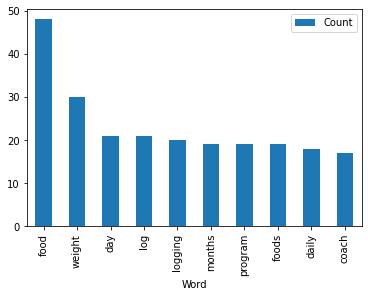

In [42]:
most_common_words(low_rating_ios_df["body"])

How many most common words to print: 10

The 10 most common words are as follows

program :  23
trial :  14
time :  14
day :  14
calories :  13
food :  12
support :  12
cancel :  11
issues :  11
weight :  11


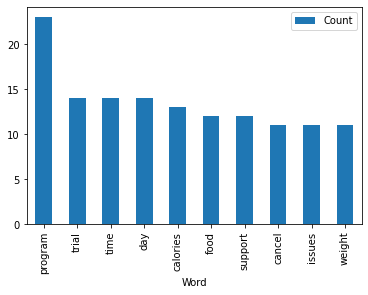

In [43]:
most_common_words(low_rating_android_df["body"])